# 0. Configuración de entorno

In [11]:
%pip install pandas scikit-learn nltk matplotlib seaborn openpyxl python-dotenv -q
%pip install -q -U google-genai 
%pip install -U google-generativeai


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached google_generativeai-0.8.5-py3-none-any.whl.metadata (3.9 kB)
  Using cached google_ai_generativelanguage-0.6.15-py3-none-any.whl.metadata (5.7 kB)
  Using cached protobuf-6.32.1-cp310-abi3-win_amd64.whl.metadata (593 bytes)
  Using cached proto_plus-1.26.1-py3-none-any.whl.metadata (2.2 kB)
  Using cached protobuf-5.29.5-cp310-abi3-win_amd64.whl.metadata (592 bytes)
  Using cached googleapis_common_protos-1.70.0-py3-none-any.whl.metadata (9.3 kB)
  Using cached httplib2-0.31.0-py3-none-any.whl.metadata (2.2 kB)
  Using cached google_auth_httplib2-0.2.0-py2.py3-none-any.whl.metadata (2.2 kB)
  Using cached uritemplate-4.2.0-py3-none-any.whl.metadata (2.6 kB)
INFO: pip is looking at multiple versions of grpcio-status to determine which version is compatible with other requirements. This could take a while.
  Using cached grpcio_status-1.75.0-py3-none-any.whl.metadata (1.1 kB)
  Using cached grpcio_status-1.74.0-py3-none-any.whl.metadata (1.1 kB)
  Using cached grpcio_statu


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

from dotenv import load_dotenv
load_dotenv()

from google import genai
from google.genai import types
client = genai.Client()

import joblib
import utils
import json
import re

dict_ods = {
    1: "Fin de la pobreza",
    3: "Salud y bienestar",
    4: "Educación de calidad",
}

In [3]:
df_original = pd.read_excel('../data/Datos_proyecto.xlsx')
df_original_clean = utils.clean_df(df_original)
df_new = pd.read_excel('../data/Datos_etapa 2.xlsx')
df_new_clean = utils.clean_df(df_new)


---

# 1. Procedimiento

Para llevar a cabo la fase de re-entrenamiento, se analizó el requerimiento del proyecto. El enunciado indica: "Una vez incorporados estos datos sintéticos junto con los news datos, al conjunto original, se debe reentrenar el modelo...".

Una interpretación literal de esta frase podría sugerir mezclar todos los conjuntos de datos (original, Datos_etapa_2 y los sintéticos) para el entrenamiento. Sin embargo, como equipo hemos identificado que este enfoque no se alinea con las buenas prácticas de la ciencia de datos, ya que introduciría un problema conocido como fuga de datos (data leakage).

La fuga de datos ocurriría porque el conjunto `Datos_etapa_2` está explícitamente destinado a evaluar el rendimiento del modelo. Si se incluye en el entrenamiento, estaríamos evaluando el modelo con datos que ya ha "visto", lo que invalidaría por completo el objetivo de los resultados y generaría métricas de rendimiento artificialmente altas y poco realistas.

para garantizar una evaluación rigurosa y metodológicamente correcta, se adoptó el siguiente procedimiento:
- **Fase 1: Establecimiento de la Línea Base (Benchmark)**
    - Cargar el mejor modelo de la etapa 1
    - Utilizar ese modelo para realizar predicciones sobre Datos_Etapa_2
    - Calcular y guardar métricas de rendimiento
- **Fase 2: Aumentación de Datos y Re-entrenamiento:**
    - Dividir el conjunto de datos originales en `train_original` y `test_original`
    - Identificar la clase minoritaria
    - Mediante técnicas de prompting generar datos sintéticos de alta calidad
    - Crear el conjunto `train_final` siendo el resulatado de `train_original` unido con los datos sinteticos generados
    - Re entrenar el modelo con los datos de `train_final`
    - Calcular y guardar métricas de rendimiento
- **Fase 3: Evaluación comparativa:**
    - Evaluar al modelo re-entrenado con el conjunto `Datos_etapa_2`
    - Comparar los resultados anteriores con los de la fase 1 para verificar si las metrica mejoraron con el prompting



---
# Fase 1: Establecimiento de linea base (Benchmark)
## 1.1 Cargar el mejor modelo de la etapa 1


In [4]:
best_model_etapa1 = joblib.load('../etapa1/best_model_etapa1.pkl')

## 1.2 Predecir los datos news

In [5]:
X_new = df_new_clean['textos']
y_new = df_new_clean['labels']
y_new_pred = best_model_etapa1.predict(X_new)

## 1.3 Calcular métricas


In [6]:

print("Accuracy:", accuracy_score(y_new, y_new_pred))
print("F1-macro:", f1_score(y_new, y_new_pred, average='macro'))
print("Precision:", precision_score(y_new, y_new_pred, average='macro'))
print("Recall:", recall_score(y_new, y_new_pred, average='macro'))
# print("\nMatriz de confusión:\n", confusion_matrix(y_new, y_new_pred))
# print("\nReporte de clasificación:\n", classification_report(y_new, y_new_pred))


Accuracy: 0.9292929292929293
F1-macro: 0.9227234753550544
Precision: 0.9430894308943089
Recall: 0.9132521225544482


Estos resultados muestran un claro overfiting en el modelo mostrando que este memoriza en su mayoria muy bien datos del mismo conjunto de train, pero que para datos nuevos suele fallar más.

---

# Fase 2: Aumentación de Datos y Re-entrenamiento
## 2.2 Dividir los datos del conjunto original en test y train


In [122]:
train_original, test_original = train_test_split(
    df_original_clean,
    test_size=0.30,
    random_state=42,
    stratify=df_original_clean["labels"]  # mantiene proporciones de clase
)


## 2.3 Identificar la clase minoritarias


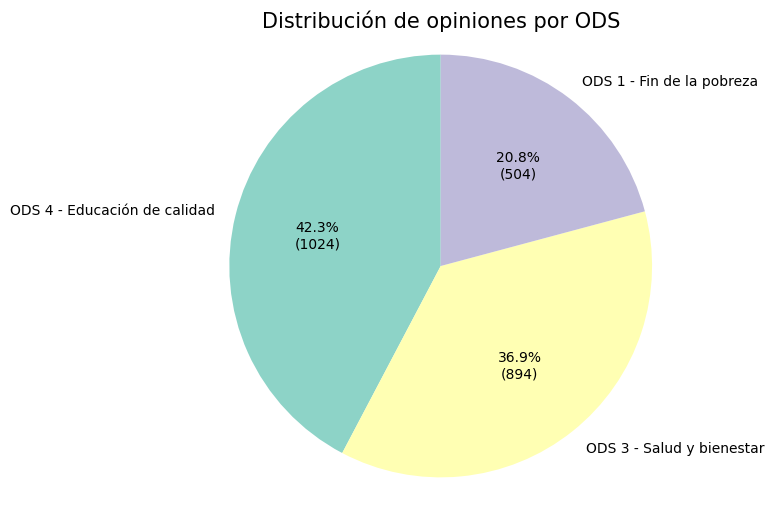

Clase minoritaria: 1


In [8]:

minoritaria = df_original_clean['labels'].value_counts().idxmin()

label_counts = df_original_clean['labels'].value_counts()
label_counts.index = label_counts.index.map(lambda i: f"ODS {i} - {dict_ods.get(i, 'Desconocido')}")

plt.figure(figsize=(6, 6))
plt.pie(
    label_counts,
    labels=label_counts.index,
    autopct=lambda p: f'{p:.1f}%\n({int(p * sum(label_counts) / 100)})',
    startangle=90,
    colors=plt.cm.Set3.colors
)

plt.title("Distribución de opiniones por ODS", fontsize=15)
plt.axis("equal")  # Mantiene el círculo perfecto
plt.show()

print(f"Clase minoritaria: {minoritaria}")


La clase minoritaria es el ODS 1 (Fin de la pobreza), mediante prompting se buscaria aumentar sus registros por lo menos hasta 900

## 2.4 Generar datos sintéticos con técnicas de prompting


In [68]:
semillas = (
    df_original[df_original['labels']==minoritaria]['textos']      # filtra solo filas de la clase minoritaria y se queda con la columna de texto
      .dropna()                          # quita textos vacíos/NaN
      .astype(str)                       # asegura que todo sea string
      .sample(                           # toma una muestra aleatoria
          min(8, sum(df_original['labels']==minoritaria)),  # hasta 8 textos, pero nunca más de los que hay
          random_state=42                      # para que la muestra sea reproducible
      )
      .tolist()                          # lo convierte a lista de strings
)
ejemplos = "\n".join(f"- {s}" for s in semillas)

prompt = f"""
Genera 200 opiniones ciudadanas breves (3-6 oraciones), en español de Colombia,
realistas y respetuosas, sobre problemáticas locales mapeadas SOLO al ODS {minoritaria}.
Definición de cada ODS: ODS 1: Fin de la pobreza, ODS 3: Salud y Bienestar, ODS 4: Educación de calidad
Requisitos:
- TODAS deben corresponder al ODS {minoritaria}.
- Varía zonas (urbano/rural), actores e instituciones; evita datos personales.
- Mantén neutralidad política y sin contenido sensible.
- TODAS deben tener más de 350 caracteres.
- Cada uno debe ser diferente, no pueden haber duplicados.
- Entrega SOLO lista válida: una lista de string con las opiniones.

Ejemplos de nuestro dataset (NO copiar, solo inspirarse):
{ejemplos if 'ejemplos' in globals() and ejemplos else '- (sin ejemplos de contexto)'}

"""

print(prompt)


Genera 200 opiniones ciudadanas breves (3-6 oraciones), en español de Colombia,
realistas y respetuosas, sobre problemáticas locales mapeadas SOLO al ODS 1.
Definición de cada ODS: ODS 1: Fin de la pobreza, ODS 3: Salud y Bienestar, ODS 4: Educación de calidad
Requisitos:
- TODAS deben corresponder al ODS 1.
- Varía zonas (urbano/rural), actores e instituciones; evita datos personales.
- Mantén neutralidad política y sin contenido sensible.
- TODAS deben tener más de 350 caracteres.
- Cada uno debe ser diferente, no pueden haber duplicados.
- Entrega SOLO lista válida: una lista de string con las opiniones.

Ejemplos de nuestro dataset (NO copiar, solo inspirarse):
- En tres (Chile, Perú y Uruguay), el efecto de este factor se vio potenciado por una mejora en la distribución, al menos en el área de distribución cercana a la línea de pobreza. Por otro lado, la tendencia a la baja de la pobreza en Argentina y República Dominicana fue, en parte, frenada —no ayudada— por cambios en la dis

In [69]:
response2 = client.models.generate_content(
    model="gemini-2.5-flash",
    contents=prompt,
    config=types.GenerateContentConfig(
        system_instruction="Eres un generador de datos sintéticos.",
        temperature=0.8,
        thinking_config=types.ThinkingConfig(thinking_budget=0)
    )
)

print(response2.text)

```json
[
  "Es preocupante ver cómo en nuestra vereda, la falta de oportunidades de empleo digno obliga a muchas familias a vivir con lo mínimo, sin acceso a servicios básicos. Las autoridades locales deben implementar programas que impulsen la economía rural y generen ingresos estables para los campesinos. La situación actual es insostenible y afecta directamente la calidad de vida de nuestros vecinos, perpetuando un ciclo de pobreza que parece no tener fin.",
  "La informalidad laboral en mi barrio es rampante y deja a muchísimas personas sin seguridad social ni ingresos fijos, lo que agrava la pobreza. Es urgente que el gobierno municipal cree incentivos para la formalización y brinde apoyo a pequeños emprendedores. La falta de acceso a un empleo estable es una barrera enorme para salir adelante y construir un futuro digno para nuestras familias.",
  "En el centro de la ciudad, hay demasiada gente viviendo en situación de calle, lo cual refleja una profunda desigualdad y falta de r

In [71]:
display(response2.usage_metadata)

GenerateContentResponseUsageMetadata(
  candidates_token_count=16475,
  prompt_token_count=1214,
  prompt_tokens_details=[
    ModalityTokenCount(
      modality=<MediaModality.TEXT: 'TEXT'>,
      token_count=1214
    ),
  ],
  total_token_count=17689
)

In [74]:
response2.text

'```json\n[\n  "Es preocupante ver cómo en nuestra vereda, la falta de oportunidades de empleo digno obliga a muchas familias a vivir con lo mínimo, sin acceso a servicios básicos. Las autoridades locales deben implementar programas que impulsen la economía rural y generen ingresos estables para los campesinos. La situación actual es insostenible y afecta directamente la calidad de vida de nuestros vecinos, perpetuando un ciclo de pobreza que parece no tener fin.",\n  "La informalidad laboral en mi barrio es rampante y deja a muchísimas personas sin seguridad social ni ingresos fijos, lo que agrava la pobreza. Es urgente que el gobierno municipal cree incentivos para la formalización y brinde apoyo a pequeños emprendedores. La falta de acceso a un empleo estable es una barrera enorme para salir adelante y construir un futuro digno para nuestras familias.",\n  "En el centro de la ciudad, hay demasiada gente viviendo en situación de calle, lo cual refleja una profunda desigualdad y falta

In [78]:
clean_s = re.sub(r"^```json\s*|\s*```$", "", response2.text.strip())
lista1 = json.loads(clean_s)
lista1

['Es preocupante ver cómo en nuestra vereda, la falta de oportunidades de empleo digno obliga a muchas familias a vivir con lo mínimo, sin acceso a servicios básicos. Las autoridades locales deben implementar programas que impulsen la economía rural y generen ingresos estables para los campesinos. La situación actual es insostenible y afecta directamente la calidad de vida de nuestros vecinos, perpetuando un ciclo de pobreza que parece no tener fin.',
 'La informalidad laboral en mi barrio es rampante y deja a muchísimas personas sin seguridad social ni ingresos fijos, lo que agrava la pobreza. Es urgente que el gobierno municipal cree incentivos para la formalización y brinde apoyo a pequeños emprendedores. La falta de acceso a un empleo estable es una barrera enorme para salir adelante y construir un futuro digno para nuestras familias.',
 'En el centro de la ciudad, hay demasiada gente viviendo en situación de calle, lo cual refleja una profunda desigualdad y falta de redes de apoyo

In [83]:
df_generated1 = pd.DataFrame({
    "textos": lista1,
    "labels": 1  # valor fijo para toda la columna
})

df_generated1

,textos,labels
0,"Es preocupante ver cómo en nuestra vereda, la ...",1
1,La informalidad laboral en mi barrio es rampan...,1
2,"En el centro de la ciudad, hay demasiada gente...",1
3,Las madres cabeza de hogar en nuestra comuna l...,1
4,La falta de acceso a créditos blandos para peq...,1
...,...,...
240,La carencia de programas de apoyo a jóvenes co...,1
241,La ausencia de programas de apoyo a personas c...,1
242,La falta de acceso a servicios de salud para p...,1
243,La carencia de programas de apoyo a pequeños p...,1


In [82]:
# Generamos otros 200 para completar los 400
response3 = client.models.generate_content(
    model="gemini-2.5-flash",
    contents=prompt,
    config=types.GenerateContentConfig(
        system_instruction="Eres un generador de datos sintéticos.",
        temperature=0.8,
        thinking_config=types.ThinkingConfig(thinking_budget=0)
    )
)

print(response3.text)

```json
[
  "Es preocupante ver cómo la falta de oportunidades laborales dignas en nuestra comunidad rural empuja a muchas familias a la pobreza extrema. Las ayudas del gobierno son insuficientes y no llegan a todos los que las necesitan, lo que agrava la situación y genera un ciclo de precariedad del que es muy difícil salir sin un apoyo sostenido y estratégico por parte de las entidades competentes.",
  "La informalidad laboral en el sector urbano es un problema grave que afecta directamente a la capacidad de las personas para salir de la pobreza. Muchos trabajadores no tienen acceso a seguridad social ni a contratos estables, lo que los deja en una situación de vulnerabilidad constante frente a cualquier eventualidad económica o de salud que pueda surgir.",
  "Considero que los programas de apoyo a pequeños agricultores son fundamentales para combatir la pobreza en las zonas rurales, pero a menudo carecen de la financiación y el seguimiento adecuados. Es esencial fortalecer estas in

In [84]:
display(response3.usage_metadata)

GenerateContentResponseUsageMetadata(
  candidates_token_count=14978,
  prompt_token_count=1214,
  prompt_tokens_details=[
    ModalityTokenCount(
      modality=<MediaModality.TEXT: 'TEXT'>,
      token_count=1214
    ),
  ],
  total_token_count=16192
)

In [85]:
clean_s = re.sub(r"^```json\s*|\s*```$", "", response3.text.strip())
lista2 = json.loads(clean_s)
lista2

['Es preocupante ver cómo la falta de oportunidades laborales dignas en nuestra comunidad rural empuja a muchas familias a la pobreza extrema. Las ayudas del gobierno son insuficientes y no llegan a todos los que las necesitan, lo que agrava la situación y genera un ciclo de precariedad del que es muy difícil salir sin un apoyo sostenido y estratégico por parte de las entidades competentes.',
 'La informalidad laboral en el sector urbano es un problema grave que afecta directamente a la capacidad de las personas para salir de la pobreza. Muchos trabajadores no tienen acceso a seguridad social ni a contratos estables, lo que los deja en una situación de vulnerabilidad constante frente a cualquier eventualidad económica o de salud que pueda surgir.',
 'Considero que los programas de apoyo a pequeños agricultores son fundamentales para combatir la pobreza en las zonas rurales, pero a menudo carecen de la financiación y el seguimiento adecuados. Es esencial fortalecer estas iniciativas y a

In [86]:
df_generated2 = pd.DataFrame({
    "textos": lista2,
    "labels": 1  # valor fijo para toda la columna
})
df_generated2

,textos,labels
0,Es preocupante ver cómo la falta de oportunida...,1
1,La informalidad laboral en el sector urbano es...,1
2,Considero que los programas de apoyo a pequeño...,1
3,La desigualdad en el acceso a servicios básico...,1
4,Es urgente implementar políticas que garantice...,1
...,...,...
239,La ausencia de programas de apoyo a la producc...,1
240,La falta de acceso a servicios de educación pa...,1
241,La dificultad para acceder a servicios de inte...,1
242,La ausencia de programas de apoyo a la producc...,1


In [87]:
df_generated = pd.concat([df_generated1, df_generated2], ignore_index=True)
df_generated

,textos,labels
0,"Es preocupante ver cómo en nuestra vereda, la ...",1
1,La informalidad laboral en mi barrio es rampan...,1
2,"En el centro de la ciudad, hay demasiada gente...",1
3,Las madres cabeza de hogar en nuestra comuna l...,1
4,La falta de acceso a créditos blandos para peq...,1
...,...,...
484,La ausencia de programas de apoyo a la producc...,1
485,La falta de acceso a servicios de educación pa...,1
486,La dificultad para acceder a servicios de inte...,1
487,La ausencia de programas de apoyo a la producc...,1


In [88]:
df_generated_clean = utils.clean_df(df_generated)

Hay 191 textos cortos (< 300 caracteres)
Textos cortos eliminados


In [89]:
# Generamos otros 200
response4 = client.models.generate_content(
    model="gemini-2.5-flash",
    contents=prompt,
    config=types.GenerateContentConfig(
        system_instruction="Eres un generador de datos sintéticos.",
        temperature=0.8,
        thinking_config=types.ThinkingConfig(thinking_budget=0)
    )
)

print(response4.text)

```json
[
  "En mi vereda, la falta de oportunidades laborales dignas es un desafío constante. Muchos jóvenes terminan el colegio y no encuentran cómo seguir adelante, lo que los empuja a buscar el sustento en actividades informales que no garantizan estabilidad ni un futuro prometedor. Es fundamental que las autoridades locales y nacionales trabajen en conjunto para atraer inversión y generar empleos formales en nuestras comunidades rurales. La gente quiere trabajar, pero necesita las condiciones para hacerlo de manera decente y segura.",
  "La situación de los pequeños agricultores en nuestra región es preocupante. Los precios de los insumos están por las nubes, y cuando llega el momento de vender nuestros productos, los intermediarios se llevan la mayor parte de las ganancias. Esto nos deja con muy poco margen para vivir y reinvertir en nuestras tierras. Necesitamos un apoyo más decidido del gobierno para asegurar precios justos para nuestros cultivos y facilitar el acceso a mercado

In [90]:
display(response4.usage_metadata)

GenerateContentResponseUsageMetadata(
  candidates_token_count=24581,
  prompt_token_count=1214,
  prompt_tokens_details=[
    ModalityTokenCount(
      modality=<MediaModality.TEXT: 'TEXT'>,
      token_count=1214
    ),
  ],
  total_token_count=25795
)

In [91]:
clean_s = re.sub(r"^```json\s*|\s*```$", "", response4.text.strip())
lista3 = json.loads(clean_s)
lista3

['En mi vereda, la falta de oportunidades laborales dignas es un desafío constante. Muchos jóvenes terminan el colegio y no encuentran cómo seguir adelante, lo que los empuja a buscar el sustento en actividades informales que no garantizan estabilidad ni un futuro prometedor. Es fundamental que las autoridades locales y nacionales trabajen en conjunto para atraer inversión y generar empleos formales en nuestras comunidades rurales. La gente quiere trabajar, pero necesita las condiciones para hacerlo de manera decente y segura.',
 'La situación de los pequeños agricultores en nuestra región es preocupante. Los precios de los insumos están por las nubes, y cuando llega el momento de vender nuestros productos, los intermediarios se llevan la mayor parte de las ganancias. Esto nos deja con muy poco margen para vivir y reinvertir en nuestras tierras. Necesitamos un apoyo más decidido del gobierno para asegurar precios justos para nuestros cultivos y facilitar el acceso a mercados directos, 

In [92]:
df_generated3 = pd.DataFrame({
    "textos": lista3,
    "labels": 1  # valor fijo para toda la columna
})
df_generated3

,textos,labels
0,"En mi vereda, la falta de oportunidades labora...",1
1,La situación de los pequeños agricultores en n...,1
2,"En el barrio donde vivo, la pobreza se ve refl...",1
3,La informalidad laboral es un problema enorme ...,1
4,La falta de acceso a créditos blandos para peq...,1
...,...,...
247,La informalidad en la venta de servicios de co...,1
248,La falta de acceso a servicios legales y de as...,1
249,La desigualdad en el acceso a la infraestructu...,1
250,La falta de oportunidades para las personas en...,1


In [113]:
df_generated = pd.concat([df_generated1, df_generated2, df_generated3], ignore_index=True)
df_generated

,textos,labels
0,"Es preocupante ver cómo en nuestra vereda, la ...",1
1,La informalidad laboral en mi barrio es rampan...,1
2,"En el centro de la ciudad, hay demasiada gente...",1
3,Las madres cabeza de hogar en nuestra comuna l...,1
4,La falta de acceso a créditos blandos para peq...,1
...,...,...
736,La informalidad en la venta de servicios de co...,1
737,La falta de acceso a servicios legales y de as...,1
738,La desigualdad en el acceso a la infraestructu...,1
739,La falta de oportunidades para las personas en...,1


In [114]:
df_generated_clean = utils.clean_df(df_generated)

Hay 39 duplicados
Duplicados eliminados
Hay 191 textos cortos (< 300 caracteres)
Textos cortos eliminados


In [115]:
df_generated_clean

,textos,labels
0,preocup ver com vered falt oportun emple dign ...,1
1,informal laboral barri rampant dej muchisim pe...,1
2,centr ciud demasi gent viv situacion call refl...,1
3,madr cabez hog comun luch diari aliment hij sa...,1
4,falt acces credit bland pequeñ agricultor regi...,1
...,...,...
701,dependent econom frijol region gener cicl pobr...,1
702,falt estrategi integral prevencion atencion vi...,1
703,informal vent servici coaching consultor traba...,1
704,falt acces servici legal asesor defens derech ...,1


In [116]:
# Se eliminan 100 al azar para cumplir con añadir cerca de 400 registros nuevos
df_generated_clean = df_generated_clean.drop(df_generated_clean.sample(100, random_state=42).index)
df_generated_clean


,textos,labels
1,informal laboral barri rampant dej muchisim pe...,1
3,madr cabez hog comun luch diari aliment hij sa...,1
4,falt acces credit bland pequeñ agricultor regi...,1
5,observ tristez com escasez aliment nutrit prec...,1
6,ausenci infraestructur basic agu potabl saneam...,1
...,...,...
698,informal vent servici cuid person mayor domici...,1
699,falt particip grup mujer indigen definicion po...,1
702,falt estrategi integral prevencion atencion vi...,1
703,informal vent servici coaching consultor traba...,1


## 2.4 Unir los datos originales de test con los sintéticos


In [123]:
df_total = pd.concat([train_original,df_generated_clean], ignore_index=True)
df_total

,textos,labels
0,podr involucr sistem acredit certific escuel c...,4
1,marc ahor establec enfoqu nacional acord integ...,4
2,hogar inform val cuatr ole pued riesg entrar s...,1
3,esfuerz profesional segu form modern educ medi...,3
4,ejempl umbral pobrez defin ingres medi pais mi...,1
...,...,...
2102,informal vent servici cuid person mayor domici...,1
2103,falt particip grup mujer indigen definicion po...,1
2104,falt estrategi integral prevencion atencion vi...,1
2105,informal vent servici coaching consultor traba...,1


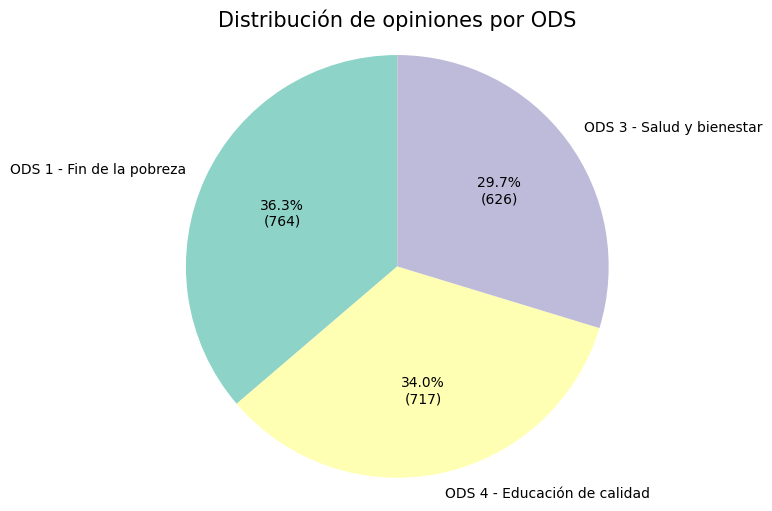

In [125]:

label_counts = df_total['labels'].value_counts()
label_counts.index = label_counts.index.map(lambda i: f"ODS {i} - {dict_ods.get(i, 'Desconocido')}")

plt.figure(figsize=(6, 6))
plt.pie(
    label_counts,
    labels=label_counts.index,
    autopct=lambda p: f'{p:.1f}%\n({int(p * sum(label_counts) / 100)})',
    startangle=90,
    colors=plt.cm.Set3.colors
)

plt.title("Distribución de opiniones por ODS", fontsize=15)
plt.axis("equal")  # Mantiene el círculo perfecto
plt.show()


## 2.5 Re entrenar el modelo


In [126]:
X_train = df_total['textos']
y_train = df_total['labels']

X_test = test_original['textos']
y_test = test_original['labels']

model = Pipeline([
    ('vect', TfidfVectorizer(
        # max_features=5000,       # puedes ajustar el número de palabras
        # ngram_range=(1,2),       # usa unigramas y bigramas
        # stop_words='spanish'     # elimina palabras comunes en español
    )),
    ('clf', LinearSVC(random_state=42, C=1, class_weight='balanced'))
])

new_model = model.fit(X_train , y_train)

y_pred = model.predict(X_test)

## 2.6 Calcular métricas


In [127]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1-score:", f1_score(y_test, y_pred, average='weighted'))

Accuracy: 0.9656593406593407
Precision: 0.9657419424646314
Recall: 0.9656593406593407
F1-score: 0.965582501265719


---

# Fase 3: Evaluación comparativa:
## 3.1 Calcular metricas del modelo re entrenado con los datos news


In [128]:
X_new = df_new_clean['textos']
y_new = df_new_clean['labels']

y_new_pred = new_model.predict(X_new)

print("Accuracy:", accuracy_score(y_new, y_new_pred))
print("F1-macro:", f1_score(y_new, y_new_pred, average='macro'))
print("Precision:", precision_score(y_new, y_new_pred, average='macro'))
print("Recall:", recall_score(y_new, y_new_pred, average='macro'))

Accuracy: 0.9292929292929293
F1-macro: 0.9198071098358042
Precision: 0.9226941226941228
Recall: 0.917829457364341


## 3.2 Compar resultados


**Tabla 1: Comparativa de Rendimiento en el Conjunto de test**


| Métrica | Modelo Original | Modelo Re-entrenado (con Aumentación) |
| :--- | :---: | :---: |
| F1-Score (Macro) | **1.000** | 0.9656 |
| Accuracy |  | 0.9656 |
| Precision (Macro) |  | 0.9657 |
| Recall (Macro) |  | 0.9657 |


**Tabla 2: Comparativa de Rendimiento en el Conjunto de PRUEBA (`Datos_etapa_2`)**

Esta tabla muestra el rendimiento de cada modelo sobre el conjunto de prueba, que contiene datos nuevos y nunca antes vistos.

| Métrica | Modelo Original | Modelo Re-entrenado (con Aumentación) |
| :--- | :---: | :---: |
| F1-Score (Macro) | 0.9233 | 0.9198 |
| Accuracy | 0.9293 | 0.9293 |
| Precision (Macro) | 0.9431 | 0.9227 |
| Recall (Macro) | 0.9132 | 0.9178 |
